# Deriving the LF parameter prior

TL;DR

All LF model parameters can be derived from statistics in [@Holmberg1988, Tables A1-A2] for an American population. See `holmberg.ipynb`. See [@Holmberg1989] for a good explanation of these statistics (that's where the abbreviations like ACFL come from). The statistics are:

1. $T_0$, the pitch period
6. $T_d = U_0/E_e$, the declination time. $U_0$ = **ac flow** (ACFL) and $E_e$ = **maximum airflow declination rate** (MFDR).
2. $E_e$: the vertical amplitude.
3. $O_q$: the open quotient,
4. $\alpha_m$, via the **speed quotient** (SPQU) $S_q$ and thus $\alpha_m$ by $\alpha_m = 3_q/(1+S_q)$ (Doval 2006).
5. $Q_a$, via the **closing quotient** (CLQU): $Q_a \simeq t_2/t_3 = CLQU/(1-O_q)$

However, these are *marginal* statistics and don't capture correlations. The correlations can be supplied using Fant (1994)'s "transformed LF" model. The three **'driving variables'** from which all other are regressed are:

1. $T_0$, the pitch period (we derive a prior for this)
2. $T_d$, the declination time (we derive a prior for this)
3. $E_e$: the vertical amplitude (always one because we work modulo scaling)

Thus, the secondary variables which are calculated from the three previous ones are:

1. $O_q$,
2. $\alpha_m$
3. $Q_a$

Bounds for all these variables can be deduced from Holmberg (1988, 1989a). But we use the theoretical bounds as this is easier and won't influence the results downstream for $\theta$ anyway.

The regression happens through Fant (1994). There are three equivalent sets of parameters, which can be converted to one another with `lfmodel.convert_lf_params()`:

1. The `T` set: original LF parameters (Fant 1985) which are used in `lfmodel.dgf()`.
2. The `R` set: rescaled ("ratios") LF parameters which can be regressed from $(T_0, T_d, E_e)$ per Fant (1994)
3. The `generic` set per Doval (2006). This is a set of variables which is well-behaved and properly bounded and 'universal'; therefore it is the set we actually model with our prior `lf.generic_params_prior()`.

## Nice quotes about LF

Note: LF does not allow **negative flow**, like ours. The only GF model that does that is the Fujisaki model:
> Note that contrarily to all other models, this [Fujisaki]
one does not exclude a negative flow due for instance to a lowering of the vocal folds following the
glottal closure. [@Degottex2010, p. 35]

LF model is the most used:
> Besides being the most used model, this one is also the
most studied in terms of spectral properties [van03, Hen01, DdH06, FL88] [@Degottex2010, p. 35]

Use the LF model to control phonation mode with the `Re` parameter: (called `Rd` here)
> This allows one to easily control the voice source with
a single parameter, which runs from Rd = 0.3 for a very adducted phonationtense, to Rd = 2.7 for a very abducted phonation
(see [@Fant1995]). From the Rd range [0.3, 2.7] two extreme values
plus a middle one were chosen. We used Rd = 0.3 to generate a **tense** phonation, Rd = 2.7 for a **lax** production, and
Rd = 1 for a **normal (modal)** voice quality [@Freixes2018]

In [1]:
%run init.ipy

from dgf.prior import period
from dgf.prior import lf
from dgf import constants
from lib import lfmodel
from lib import klatt

import corner

# FOR SOME EXTREMELY WEIRD REASON THE LINES BELOW NEED TO
# BE EXECUTED IN THIS ORDER, OTHERWISE JOBLIB WILL RECALCULATE CACHE!!!!
# (which takes O(1 hour))
period.fit_period_trajectory_bijector()
lf.generic_params_trajectory_prior(1);

2022-10-21 17:34:21.800986: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-21 17:34:21.801036: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-10-21 17:34:21.801040: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


[Memory]2.0s, 0.0min    : Loading get_aplawd_training_pairs...
[Memory]35.1s, 0.6min   : Loading run_nested...
[Memory]36.6s, 0.6min   : Loading run_nested...
[Memory]37.9s, 0.6min   : Loading run_nested...
[Memory]39.3s, 0.7min   : Loading run_nested...
[Memory]39.3s, 0.7min   : Loading sample_lf_params...
[Memory]40.8s, 0.7min   : Loading run_nested...
[Memory]40.9s, 0.7min   : Loading get_aplawd_training_pairs...
[Memory]43.0s, 0.7min   : Loading run_nested...
[Memory]44.4s, 0.7min   : Loading run_nested...
[Memory]45.8s, 0.8min   : Loading run_nested...
[Memory]47.3s, 0.8min   : Loading run_nested...


## Sampling Fant's `R` parameters

Note that `Rg` can be larger than 1, unlike `Ra `and `Rg` (Fant 1994, Fig. 3), because it is actually an inverse ratio: $R_g = T_0/2T_p$.

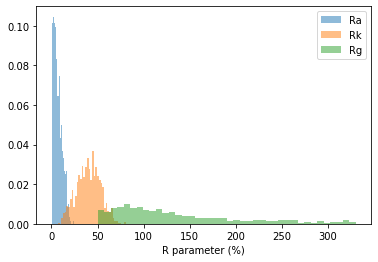

In [2]:
rng = np.random.default_rng()

samples = np.vstack([lf.sample_R_triple(Re, rng) for Re in uniform(0.3, 2.7, size=1000)])
R = dict(Ra = samples[:,0], Rk = samples[:,1], Rg = samples[:,2])

for k, v in R.items():
    hist(v*100, density=True, bins=40, alpha=.5, label=k);

legend()
xlabel("R parameter (%)")
show()

## Sampling the LF parameters and fitting a prior

`p` contains all three parametrizations: `R`, `T`, and `generic`.

In [3]:
%%time
p = lf.sample_lf_params()

[Memory]48.6s, 0.8min   : Loading sample_lf_params...
CPU times: user 4.69 ms, sys: 76 µs, total: 4.76 ms
Wall time: 3.05 ms


In [4]:
samples = np.vstack([p[v] for v in constants.LF_GENERIC_PARAMS]).T
samples.shape

(63598, 4)

One interesting extra correlation not shown here is that of `p['power']` with the generic LF parameters. It has the clearest, most Gaussian-like correlations (in the z domain) but is strictly not an LF generic parameter, so not shown here.

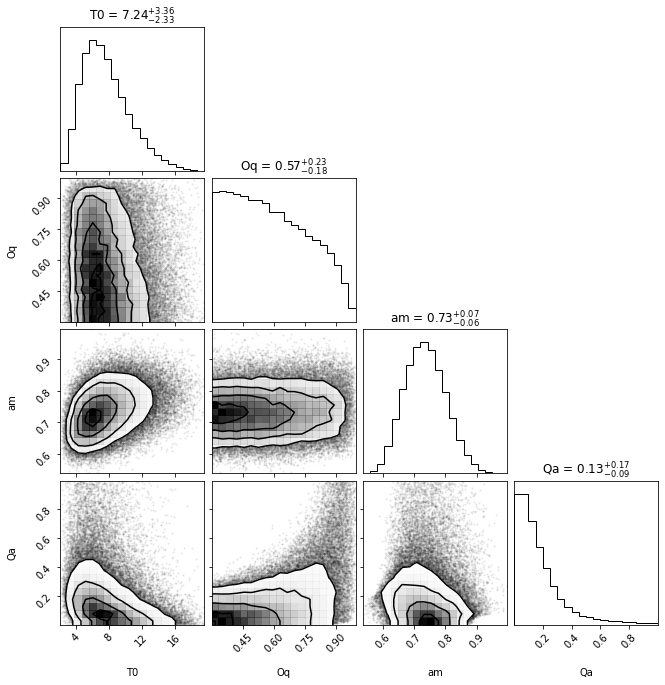

In [5]:
# Cornerplot of regressed (simulated) samples
fig = corner.corner(
    samples,
    labels=constants.LF_GENERIC_PARAMS,
    show_titles=True,
    smooth=.2
)

In [6]:
prior = lf.generic_params_prior()

[Memory]49.6s, 0.8min   : Loading sample_lf_params...
[Memory]49.6s, 0.8min   : Loading run_nested...


The samples and their probability are well behaved, unlike with our previous version where there would be ginormous outliers of the log prob.

In [7]:
theta, theta_lp = prior.experimental_sample_and_log_prob(samples.shape[0], seed=jax.random.PRNGKey(10))

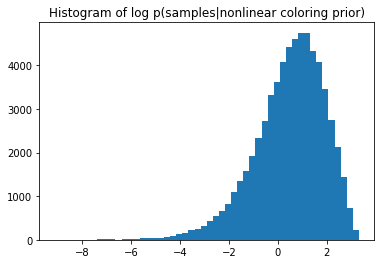

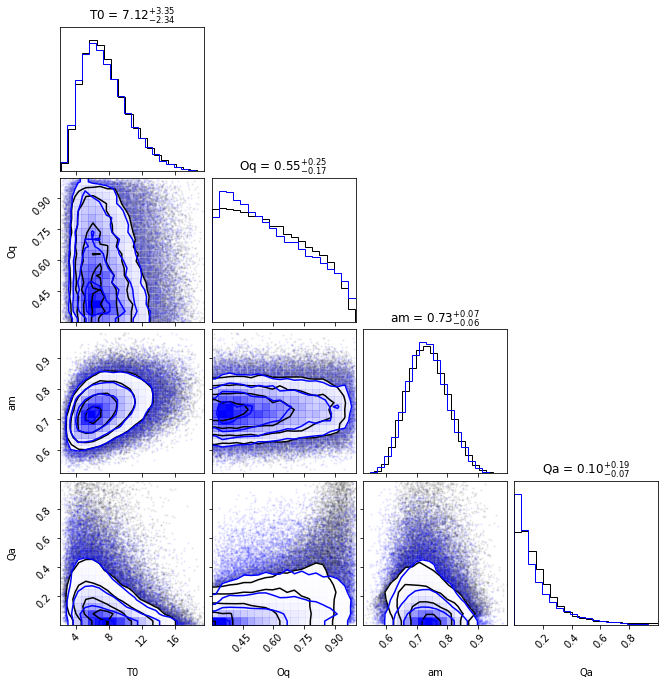

In [8]:
hist(np.array(theta_lp),bins=50)
title("Histogram of log p(samples|nonlinear coloring prior)")
show();

# Overlaying with an alpha is not possible, see https://github.com/dfm/corner.py/issues/112
corner.corner(
    np.array(theta),
    labels=constants.LF_GENERIC_PARAMS,
    show_titles=True,
    smooth=.2,
    fig=fig,
    color="blue"
)

## Simulate trajectories of the generic LF parameters

The envelope function is the one of the period learned from APLAWD.

[Memory]53.6s, 0.9min   : Loading sample_lf_params...
[Memory]53.6s, 0.9min   : Loading run_nested...
[Memory]53.6s, 0.9min   : Loading get_aplawd_training_pairs...
[Memory]55.7s, 0.9min   : Loading run_nested...
[Memory]57.1s, 1.0min   : Loading run_nested...
[Memory]58.5s, 1.0min   : Loading run_nested...
[Memory]59.9s, 1.0min   : Loading run_nested...
log p(x) = 441.3165325348037


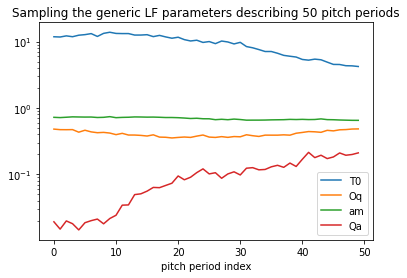

In [9]:
num_pitch_periods = 50

prior = lf.generic_params_trajectory_prior(num_pitch_periods)

x = prior.sample(seed=jaxkey(5))

title(f'Sampling the generic LF parameters describing {num_pitch_periods} pitch periods')
plot(x, label=constants.LF_GENERIC_PARAMS)
yscale('log')
legend()
xlabel('pitch period index')

print('log p(x) =', prior.log_prob(x))

## Convert the trajectories into DGF waveforms

The inferred lengthscale sounds rushed, but this is normal and due to the data: we learned the lengthscale from generally short fragments of voiced speech, with 75% of data points having a length of less than 53 consecutive pitch periods.

**About the log probability of the sampled $u(t)$.** It is possible to calculate the probability of the sampled *waveforms* (which is not equal to the probability of the underlying samples) similarly as is done in `source.py`. First calculate the probability `log_prob_xg` of the `generic` LF parameters `xg` and convert it to the probability `log_prob_p` of the `T` LF parameters in `p`:
````python
xg, log_prob_xg = prior.experimental_sample_and_log_prob(seed=jax.random.PRNGKey(seed))

def xg_to_lf_t_params(xg, log_prob_xg):
    def xg_to_xt(xg):
        p = generic_params_to_dict(xg, squeeze=True)
        p = convert_lf_params(p, 'generic -> T')
        return jnp.array([p[k] for k in constants.LF_T_PARAMS]), p

    jacobian, p = jax.vmap(jax.jacobian(xg_to_xt, has_aux=True), in_axes=0)(xg)
    log_prob_p = log_prob_xg - jnp.sum(jnp.linalg.slogdet(jacobian)[1])
    return p, log_prob_p
````
Then add noise to the waveform and calculate the probability of the DGF train with a Laplace approximation. This is what is done in `source.sample_and_logprob_q()`.

## ***TEEESSTTTTIINNGNGN****

**Just use vmap to caclulate the jacobian for the log prob of waveform, because each pitch period is independent.**

In [55]:
prior = lf.generic_params_trajectory_prior(1)

[Memory]2165.3s, 36.1min: Loading sample_lf_params...
[Memory]2165.3s, 36.1min: Loading run_nested...
[Memory]2165.3s, 36.1min: Loading get_aplawd_training_pairs...
[Memory]2167.4s, 36.1min: Loading run_nested...
[Memory]2168.7s, 36.1min: Loading run_nested...
[Memory]2170.1s, 36.2min: Loading run_nested...
[Memory]2171.4s, 36.2min: Loading run_nested...


In [56]:
prior.experimental_sample_and_log_prob(seed=jaxkey())

(DeviceArray([[4.32208673, 0.49975262, 0.71486512, 0.23456122]], dtype=float64),
 DeviceArray(0.73110981, dtype=float64))

In [65]:
sample_and_log_prob_xt(prior, jaxkey())

(DeviceArray([7.63970487, 4.05287874, 2.8304008 , 0.98237554], dtype=float64),
 DeviceArray(-4.54754452, dtype=float64),
 {'T0': DeviceArray(7.63970487, dtype=float64),
  'Oq': DeviceArray(0.530502, dtype=float64),
  'am': DeviceArray(0.698368, dtype=float64),
  'Qa': DeviceArray(0.27388435, dtype=float64),
  'Te': DeviceArray(4.05287874, dtype=float64),
  'Tp': DeviceArray(2.8304008, dtype=float64),
  'Ta': DeviceArray(0.98237554, dtype=float64)})

In [10]:
num_pitch_periods = 1000
vowel = 10

# None values use the period GP
envelope_kernel_name = None
envelope_lengthscale = None
envelope_noise_sigma = None

prior = lf.generic_params_trajectory_prior(
    num_pitch_periods
)

t, u = lf.sample_dgf(
    num_pitch_periods,
    prior,
    seed=rng.integers(1000)
)
title(f'Sampled u(t)')
plot(t, u)
xlabel('msec')
show()

t, d = klatt.gen_vowel(vowel, u, t)
title(f'Sampled u(t) convolved with a constant vowel')
plot(t, d)
xlabel('msec')
show()
klatt.play(t, d)

[Memory]63.8s, 1.1min   : Loading sample_lf_params...
[Memory]63.8s, 1.1min   : Loading run_nested...
[Memory]63.8s, 1.1min   : Loading get_aplawd_training_pairs...
[Memory]65.9s, 1.1min   : Loading run_nested...
[Memory]67.4s, 1.1min   : Loading run_nested...
[Memory]68.9s, 1.1min   : Loading run_nested...
[Memory]70.4s, 1.2min   : Loading run_nested...


2022-10-21 14:54:21.678332: W external/org_tensorflow/tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.36GiB (rounded to 5757889536)requested by op 
2022-10-21 14:54:21.678561: W external/org_tensorflow/tensorflow/tsl/framework/bfc_allocator.cc:492] ****************************************__________________________________________*********___****_*
2022-10-21 14:54:21.678783: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2153] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 5757889360 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   687.3KiB
              constant allocation:        16B
        maybe_live_out allocation:  610.12MiB
     preallocated temp allocation:    5.36GiB
  preallocated temp fragmentation:       320B (0.00%)
                 total allocation:    5.96GiB
              total fr

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 5757889360 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   687.3KiB
              constant allocation:        16B
        maybe_live_out allocation:  610.12MiB
     preallocated temp allocation:    5.36GiB
  preallocated temp fragmentation:       320B (0.00%)
                 total allocation:    5.96GiB
              total fragmentation:     1.4KiB (0.00%)
Peak buffers:
	Buffer 1:
		Size: 2.38GiB
		Operator: op_name="jit(dgf)/jit(main)/jit(_piecewise)/iota[dtype=int64 shape=(1000, 4, 79970) dimension=1]" source_file="/home/marnix/thesis/py/lib/lfmodel.py" source_line=61
		XLA Label: fusion
		Shape: s64[4,1000,79970]
		==========================

	Buffer 2:
		Size: 2.38GiB
		Operator: op_name="jit(dgf)/jit(main)/jit(_piecewise)/jit(_cumulative_reduction)/reduce_window_sum[window_dimensions=(1, 4, 1) window_strides=(1, 1, 1) padding=((0, 0), (3, 0), (0, 0)) base_dilation=(1, 1, 1) window_dilation=(1, 1, 1)]" source_file="/home/marnix/thesis/py/lib/lfmodel.py" source_line=61
		XLA Label: fusion
		Shape: s64[4,1000,79970]
		==========================

	Buffer 3:
		Size: 610.12MiB
		Operator: op_name="jit(dgf)/jit(main)/jit(_piecewise)/reduce[computation=<function _compute_argminmax.<locals>.reducer_fn at 0x7f1b682f3ac0> consts=() dimensions=(1,)]" source_file="/home/marnix/thesis/py/lib/lfmodel.py" source_line=61
		XLA Label: reduce
		Shape: s64[1000,79970]
		==========================

	Buffer 4:
		Size: 610.12MiB
		Operator: op_name="jit(dgf)/jit(main)/select_n" source_file="/home/marnix/thesis/py/lib/lfmodel.py" source_line=103
		XLA Label: fusion
		Shape: f64[1000,79970]
		==========================

	Buffer 5:
		Size: 624.8KiB
		Entry Parameter Subshape: f64[79970]
		==========================

	Buffer 6:
		Size: 7.8KiB
		Operator: op_name="jit(dgf)/jit(main)/jit(_where)/select_n" source_file="/home/marnix/thesis/py/lib/lfmodel.py" source_line=18
		XLA Label: fusion
		Shape: f64[1000]
		==========================

	Buffer 7:
		Size: 7.8KiB
		Operator: op_name="jit(dgf)/jit(main)/jit(_where)/select_n" source_file="/home/marnix/thesis/py/lib/lfmodel.py" source_line=18
		XLA Label: fusion
		Shape: f64[1000]
		==========================

	Buffer 8:
		Size: 7.8KiB
		Operator: op_name="jit(dgf)/jit(main)/jit(_where)/select_n" source_file="/home/marnix/thesis/py/lib/lfmodel.py" source_line=18
		XLA Label: fusion
		Shape: f64[1000]
		==========================

	Buffer 9:
		Size: 7.8KiB
		Operator: op_name="jit(dgf)/jit(main)/jit(_where)/select_n" source_file="/home/marnix/thesis/py/lib/lfmodel.py" source_line=18
		XLA Label: fusion
		Shape: f64[1000]
		==========================

	Buffer 10:
		Size: 7.8KiB
		Entry Parameter Subshape: f64[1000]
		==========================

	Buffer 11:
		Size: 7.8KiB
		Entry Parameter Subshape: f64[1000]
		==========================

	Buffer 12:
		Size: 7.8KiB
		Entry Parameter Subshape: f64[1000]
		==========================

	Buffer 13:
		Size: 7.8KiB
		Entry Parameter Subshape: f64[1000]
		==========================

	Buffer 14:
		Size: 7.8KiB
		Entry Parameter Subshape: f64[1000]
		==========================

	Buffer 15:
		Size: 7.8KiB
		Entry Parameter Subshape: f64[1000]
		==========================



In [ ]:
x = lf.generic_params_prior().sample(seed=jaxkey())
lf.generic_params_to_dict(x, squeeze=True)